<a href="https://colab.research.google.com/github/willkwon-math/class-for-deeplearning/blob/master/Lecture3_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!




/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!



torch.Size([10, 1, 28, 28])
tensor([5, 2, 7, 4, 2, 1, 1, 3, 7, 0])




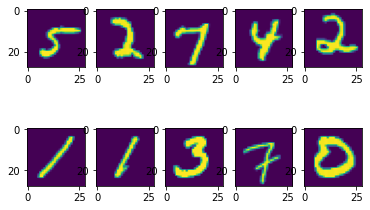

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
from torchvision import datasets

### dataset 불러오기


import sys
sys.path.insert(0, "..")

# MNIST preprocessing
mnist_transform = transforms.Compose([
                                      transforms.ToTensor(),
])

mnist_train = torchvision.datasets.MNIST(root="./", train =True, download=True, transform=mnist_transform)
mnist_test = torchvision.datasets.MNIST(root="./", train =False, download=True, transform=mnist_transform)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
)

testset = datasets.MNIST(
    root = './data',
    train = False,
    download = True,
    transform = transform
)
testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size = 4,
    shuffle = False
)


from torch.utils.data import DataLoader

batch_size = 10
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)

for x, y in train_loader:
  print(x.shape)
  print(y)
  fig = plt.figure()
  for i in range(batch_size):
    plt.subplot(2, batch_size //2, i+1)
    plt.imshow(x[i].reshape(x[i].shape[1],-1))
  break

In [3]:
## making a model

class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.layer0 = torch.nn.Linear(28*28, 64, bias=True) #we first take linear transform
    self.act = torch.nn.ReLU() #second layer - use activation function
    self.layer1 = torch.nn.Linear(64, 32, bias = False) #another linear transform
    self.layer2 = torch.nn.Linear(32, 10, bias=False)

  def forward(self, inputs):
    inputs = inputs.view(-1, 28*28) #match dimension
    hidden = self.layer0(inputs)
    hidden = self.act(hidden) #use activation function
    hidden = self.layer1(hidden)
    hidden = self.act(hidden)
    outputs = self.layer2(hidden) 
    return outputs

model = MLP() #GPU 


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03)

torch.Size([64, 784])
torch.Size([64])
torch.Size([32, 64])
torch.Size([10, 32])


Some added one

In [4]:
class accumulator():
  def __init__(self):
    self.cnt = 0
    self.obs = 0
    self.loss = 0
  
  def add(self,predict,output):
    assert len(predict) == len(output)

    self.cnt += self.count(predict, output).cpu().numpy()
    self.obs += len(predict)

  def count(self, predict, output):
    correct = torch.sum(torch.argmax(predict, dim=1) == output)

    return correct

  def loss_update(self, loss, batch_size):
    self.loss += loss * batch_size

  def running_stat(self):
    if self.obs != 0:
      run_acc = 100 * self.cnt / self.obs
      run_loss = self.loss / self.obs
    else:
      run_acc = 0
      run_loss = 0

    return run_acc, run_loss

  def reset(self):
    self.__init__()








## learning
batch_size = 128
train_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

num_epochs = 200
accuracy_graph = {'train':[], 'test':[], 'epoch': []}
loss_graph = {'train':[], 'test':[], 'epoch': []}

for epoch in range(num_epochs):

  train_accuracy = accumulator()
  test_accuracy = accumulator()

  for train_x, train_y in train_loader:
    train_predict = model(train_x)
    loss = criterion(train_predict, train_y)

    #backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_accuracy.add(train_predict, train_y)
    train_accuracy.loss_update(loss, batch_size)

  if epoch % 10 ==0:
    #loss=criterion(train_predict, train_y)
    #loss_graph['train'].append(loss) #train loss

    cnt = 0
    for test_x, test_y in test_loader:
      with torch.autograd.no_grad():
        test_predict = model(test_x)
        test_accuracy.add(test_predict, test_y)
        #correct = torch.sum(torch.argmax(test_predict, dim=1) == test_y)
        #cnt += correct.cpu().numpy() #test accuracy
        loss_test = criterion(test_predict, test_y)
        test_accuracy.loss_update(loss_test, batch_size)
    
    train_acc, train_loss = train_accuracy.running_stat()
    test_acc, test_loss = test_accuracy.running_stat()
    accuracy_graph['train'].append(train_acc)
    accuracy_graph['test'].append(test_acc)
    accuracy_graph['epoch'].append(epoch)
    loss_graph['train'].append(train_loss)
    loss_graph['test'].append(test_loss) #test loss
    loss_graph['epoch'].append(epoch) 

    print("\ntest accuracy: {:.2f} %, test accuracy: {:.2f} %".format(train_acc, test_acc))
    print("epoch:{}, train_loss:{:.4f}, test_loss:{:.4f}".format(epoch+1, loss, loss_test))

    train_accuracy.reset(), test_accuracy.reset()


test accuracy: 58.32 %, test accuracy: 85.23 %
epoch:1, train_loss:0.6388, test_loss:0.5208

test accuracy: 94.80 %, test accuracy: 94.99 %
epoch:11, train_loss:0.2324, test_loss:0.0672

test accuracy: 96.83 %, test accuracy: 96.12 %
epoch:21, train_loss:0.0674, test_loss:0.1082

test accuracy: 97.82 %, test accuracy: 96.97 %
epoch:31, train_loss:0.0735, test_loss:0.0865

test accuracy: 98.45 %, test accuracy: 97.12 %
epoch:41, train_loss:0.1265, test_loss:0.1254

test accuracy: 98.88 %, test accuracy: 97.38 %
epoch:51, train_loss:0.0178, test_loss:0.0181

test accuracy: 99.21 %, test accuracy: 97.35 %
epoch:61, train_loss:0.0196, test_loss:0.3444

test accuracy: 99.46 %, test accuracy: 97.50 %
epoch:71, train_loss:0.0088, test_loss:0.0514

test accuracy: 99.66 %, test accuracy: 97.49 %
epoch:81, train_loss:0.0162, test_loss:0.1423

test accuracy: 99.78 %, test accuracy: 97.26 %
epoch:91, train_loss:0.0264, test_loss:0.7778

test accuracy: 99.88 %, test accuracy: 97.58 %
epoch:101, tr

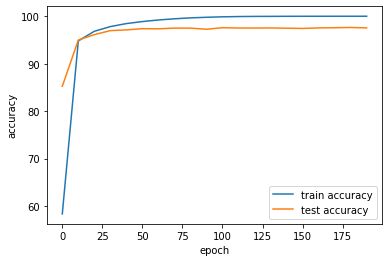

In [5]:
plt.plot(accuracy_graph['epoch'], accuracy_graph['train'], label= "train accuracy");
plt.plot(accuracy_graph['epoch'], accuracy_graph['test'], label= "test accuracy");
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

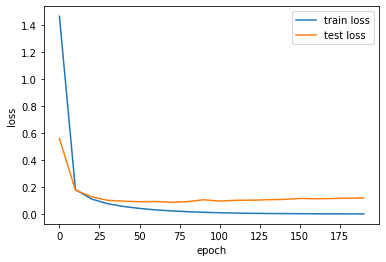

In [7]:
plt.plot(loss_graph['epoch'],loss_graph['train'], label="train loss");
plt.plot(loss_graph['epoch'],loss_graph['test'], label="test loss");
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

## Weight 를 추가했을 때

In [12]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03, weight_decay=1e-3)

for p in model.parameters():
  try:
    torch.nn.init.xavier_normal_(p)
  except ValueError:
    continue

## learning
batch_size = 128
train_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

num_epochs = 200
accuracy_graph = {'train':[], 'test':[], 'epoch': []}
loss_graph = {'train':[], 'test':[], 'epoch': []}

for epoch in range(num_epochs):

  train_accuracy = accumulator()
  test_accuracy = accumulator()

  for train_x, train_y in train_loader:
    train_predict = model(train_x)
    loss = criterion(train_predict, train_y)

    #backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_accuracy.add(train_predict, train_y)
    train_accuracy.loss_update(loss, batch_size)

  if epoch % 10 ==0:
    #loss=criterion(train_predict, train_y)
    #loss_graph['train'].append(loss) #train loss

    cnt = 0
    for test_x, test_y in test_loader:
      with torch.autograd.no_grad():
        test_predict = model(test_x)
        test_accuracy.add(test_predict, test_y)
        #correct = torch.sum(torch.argmax(test_predict, dim=1) == test_y)
        #cnt += correct.cpu().numpy() #test accuracy
        loss_test = criterion(test_predict, test_y)
        test_accuracy.loss_update(loss_test, batch_size)
    
    train_acc, train_loss = train_accuracy.running_stat()
    test_acc, test_loss = test_accuracy.running_stat()
    accuracy_graph['train'].append(train_acc)
    accuracy_graph['test'].append(test_acc)
    accuracy_graph['epoch'].append(epoch)
    loss_graph['train'].append(train_loss)
    loss_graph['test'].append(test_loss) #test loss
    loss_graph['epoch'].append(epoch) 

    print("\ntest accuracy: {:.2f} %, test accuracy: {:.2f} %".format(train_acc, test_acc))
    print("epoch:{}, train_loss:{:.4f}, test_loss:{:.4f}".format(epoch+1, loss, loss_test))

    train_accuracy.reset(), test_accuracy.reset() 


test accuracy: 76.79 %, test accuracy: 89.43 %
epoch:1, train_loss:0.5257, test_loss:0.1890

test accuracy: 95.51 %, test accuracy: 95.29 %
epoch:11, train_loss:0.2512, test_loss:0.1284

test accuracy: 97.06 %, test accuracy: 96.52 %
epoch:21, train_loss:0.2529, test_loss:0.0340

test accuracy: 97.79 %, test accuracy: 97.02 %
epoch:31, train_loss:0.0307, test_loss:0.0118

test accuracy: 98.19 %, test accuracy: 97.19 %
epoch:41, train_loss:0.0427, test_loss:0.0846

test accuracy: 98.41 %, test accuracy: 97.23 %
epoch:51, train_loss:0.1450, test_loss:0.0158

test accuracy: 98.61 %, test accuracy: 97.40 %
epoch:61, train_loss:0.0836, test_loss:0.1768

test accuracy: 98.74 %, test accuracy: 97.53 %
epoch:71, train_loss:0.0259, test_loss:0.0161

test accuracy: 98.88 %, test accuracy: 97.49 %
epoch:81, train_loss:0.0371, test_loss:0.0701

test accuracy: 98.91 %, test accuracy: 97.65 %
epoch:91, train_loss:0.0417, test_loss:0.0012

test accuracy: 99.00 %, test accuracy: 97.65 %
epoch:101, tr

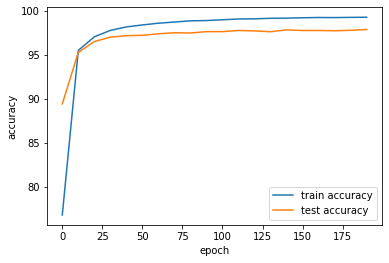

In [13]:
plt.plot(accuracy_graph['epoch'], accuracy_graph['train'], label= "train accuracy");
plt.plot(accuracy_graph['epoch'], accuracy_graph['test'], label= "test accuracy");
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy") 
plt.show()

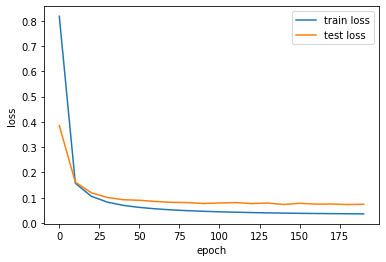

In [14]:
plt.plot(loss_graph['epoch'],loss_graph['train'], label="train loss");
plt.plot(loss_graph['epoch'],loss_graph['test'], label="test loss");
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()